In [90]:
# Libraries
import os
import json
import re
from langdetect import detect # Library for language detection
from spellchecker import SpellChecker
import string
import spacy
from sklearn_crfsuite import CRF
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.preprocessing import LabelEncoder
import numpy as np

In [91]:
os.chdir('C:\\GitHub Repositories\\NLP-Detection-of-Negation-and-Uncertainty-Project-24\\Data')

In [92]:
# Loading the json file
loading = open("negacio_train_v2024.json")
training_data = json.load(loading)
print(len(training_data))

254


In [93]:
!python -m spacy download es_core_news_sm
!python -m spacy download ca_core_news_sm

     ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
     --------------------------------------- 0.0/12.9 MB 325.1 kB/s eta 0:00:40
     --------------------------------------- 0.1/12.9 MB 737.3 kB/s eta 0:00:18
     - -------------------------------------- 0.3/12.9 MB 1.8 MB/s eta 0:00:07
     -- ------------------------------------- 0.7/12.9 MB 3.4 MB/s eta 0:00:04
     -- ------------------------------------- 0.9/12.9 MB 3.7 MB/s eta 0:00:04
     --- ------------------------------------ 1.1/12.9 MB 3.6 MB/s eta 0:00:04
     --- ------------------------------------ 1.3/12.9 MB 3.6 MB/s eta 0:00:04
     ---- ----------------------------------- 1.3/12.9 MB 3.4 MB/s eta 0:00:04
     ---- ----------------------------------- 1.4/12.9 MB 3.1 MB/s eta 0:00:04
     ---- ----------------------------------- 1.5/12.9 MB 3.0 MB/s eta 0:00:04
     ---- ----------------------------------- 1.5/12.9 MB 2.9 MB

In [94]:
# 1 Remove pacient information and redacted entries
def remove_pacient_info(text):
    # Remove lines starting with "nº historia clinica:" and ending with "motiu d'ingres"
    text = re.sub(r'nº historia clinica:.*?motiu d\'ingres', '', text, flags=re.DOTALL)
    # Remove lines starting with "nhc" and ending with "lopd"
    text = re.sub(r'nhc.*?lopd', '', text, flags=re.DOTALL)
    # Remove all asterisks '*'
    text = text.replace('*', '')
    return text


# 2 Remove Punctuation (Able to be turned ON/OFF)
def remove_punctuation(text):
    # Define a translation table to map punctuation to None
    translator = str.maketrans('', '', string.punctuation)
    # Remove punctuation using the translation table
    text = text.translate(translator)
    return text


# 3 Spell cheking with language detection (Able to be turned ON/OFF)
# Load language models for Spanish and Catalan
nlp_es = spacy.load("es_core_news_sm")
nlp_ca = spacy.load("ca_core_news_sm")

def lemmatize_text(text):
    # Detect the language of the text
    language = detect(text)

    # Tokenize the text using the appropriate language model
    if language == 'ca':
        doc = nlp_ca(text)
    else:
        doc = nlp_es(text)

    # Lemmatize tokens
    lemmatized_tokens = []
    for token in doc:
        # Check if the token is a punctuation or whitespace
        if not token.is_punct and not token.is_space:
            # Lemmatize the token
            lemmatized_token = token.lemma_ if token.lemma_ != '-PRON-' else token.text
            lemmatized_tokens.append(lemmatized_token)
        else:
            lemmatized_tokens.append(token.text)

    # Join the tokens back into text
    lemmatized_text = ' '.join(lemmatized_tokens)
    return lemmatized_text


# 4 Tokenization with coordinates of the original text for (evaluation)
def tokenize_with_coordinates(text):
    # Tokenize the text while preserving the coordinates
    tokens_with_coordinates = []
    token_start = 0
    for token in re.finditer(r'\S+', text):
        token_text = token.group(0)
        token_end = token_start + len(token_text)
        tokens_with_coordinates.append((token_text, token_start, token_end))
        # Update token start position for the next token
        token_start = token_end
    return tokens_with_coordinates


# Main function to process the text
def pre_process_text(text, remove_punctuation_call=True, spell_check_call=True):

    # 1 Remove pacient information and redacted entries
    preprocessed_text = remove_pacient_info(text)

    # 2 Remove punctuation if specified
    if remove_punctuation_call:
        preprocessed_text = remove_punctuation(preprocessed_text)

    # 3 Spell check and lemmatize if specified
    if spell_check_call:
        preprocessed_text = lemmatize_text(preprocessed_text)

    # 4 Tokenize the text with coordinates
    tokens_with_coordinates = tokenize_with_coordinates(preprocessed_text)

    return tokens_with_coordinates

## <span style="color:red; font-size:larger;">**DATA ANNOTATION**</span>


In [95]:
def strip_tokens(tagged_text):
    def find_indices(tokens, start_token, end_token, occurrence=1):
        start_index = None
        end_index = None
        end_token_count = 0
        for i, (word, _, _) in enumerate(tokens):
            if word == start_token and start_index is None:
                start_index = i
            if word == end_token:
                end_token_count += 1
                if end_token_count == occurrence:
                    end_index = i
                    break
        return start_index, end_index

    # Remove sections from "nº" to the second occurrence of "d'ingres"
    start1, end1 = find_indices(tagged_text, 'nº', "d'ingres", occurrence=2)
    if end1 is not None:
        end1 += 1  # Include the end token

    # If the indices are found, remove the section
    new_tagged_text = []
    if start1 is not None and end1 is not None:
        new_tagged_text = tagged_text[:start1] + tagged_text[end1:]
    else:
        new_tagged_text = tagged_text[:]

    # Continuously find and remove all sections from "nhc" to "lopd"
    while True:
        start2, end2 = find_indices(new_tagged_text, 'nhc', 'lopd')
        if start2 is not None and end2 is not None:
            end2 += 1  # Include the end token
            new_tagged_text = new_tagged_text[:start2] + new_tagged_text[end2:]
        else:
            break

    return new_tagged_text

def tag_words_from_json(json_data):
    # Initialize lists for all tagged texts and counts
    all_tagged_texts = []
    all_counts = []

    # Iterate through each entry in the JSON data
    for entry in json_data:
        # Extract text and predictions from JSON entry
        text = entry['data']['text']
        predictions = entry['predictions'][0]['result']

        # Initialize counters
        counts = {'NEG': 0, 'NSCO': 0, 'UNC': 0, 'USCO': 0}

        # Initialize tokens and their coordinates
        tokens = []
        start_pos = 0

        # Split text into tokens while tracking their start and end positions
        for word in text.split():
            start = text.find(word, start_pos)
            end = start + len(word)
            tokens.append((word, start, end))
            start_pos = end

        # Initialize tags list
        tags = ['O'] * len(tokens)

        # Tag each word
        for pred in predictions:
            pred_start = pred['value']['start']
            pred_end = pred['value']['end']
            label = pred['value']['labels'][0]

            if label in counts:
                counts[label] += 1
                for i, (word, start, end) in enumerate(tokens):
                    if start < pred_end and end > pred_start:
                        tags[i] = label

        # Combine tokens with tags
        tagged_text = [(token[0], (token[1], token[2]), tags[i]) for i, token in enumerate(tokens)]

        # Strip unwanted tokens
        stripped_tagged_text = strip_tokens(tagged_text)

        # Append the results to the lists
        all_tagged_texts.append(stripped_tagged_text)
        all_counts.append(counts)

    # Return the list of tagged words and counts for all entries
    return all_tagged_texts,all_counts

In [96]:
# Example usage with all entries
labels, counts_list = tag_words_from_json(training_data)

print("Number of entries in the entry:", len(labels))
print(labels[0]) # Print out an example entry
print(counts_list[0])

Number of entries in the entry: 254
[('paciente', (315, 323), 'O'), ('que', (324, 327), 'O'), ('ingresa', (328, 335), 'O'), ('de', (336, 338), 'O'), ('forma', (339, 344), 'O'), ('programada', (345, 355), 'O'), ('para', (356, 360), 'O'), ('realizacion', (361, 372), 'O'), ('de', (373, 375), 'O'), ('uretrotomia', (376, 387), 'O'), ('interna', (388, 395), 'O'), ('.', (396, 397), 'O'), ('antecedents', (398, 409), 'O'), ('alergia', (410, 417), 'O'), ('a', (418, 419), 'O'), ('penicilina', (420, 430), 'O'), ('y', (431, 432), 'O'), ('cloramfenicol', (433, 446), 'O'), ('.', (447, 448), 'O'), ('no', (449, 451), 'NEG'), ('habitos', (452, 459), 'NSCO'), ('toxicos.', (460, 468), 'NSCO'), ('antecedentes', (469, 481), 'O'), ('medicos:', (482, 490), 'O'), ('bloqueo', (491, 498), 'O'), ('auriculoventricular', (499, 518), 'O'), ('de', (519, 521), 'O'), ('primer', (522, 528), 'O'), ('grado', (529, 534), 'O'), ('hipertension', (535, 547), 'O'), ('arterial.', (548, 557), 'O'), ('diverticulosis', (558, 572),

## <span style="color:red; font-size:larger;">**FEATURE EXTRACTION FUNCTIONS**</span>


In [97]:
import spacy
import logging
from spacy.tokens import Doc

# Initialize your SpaCy models here
nlp_es = spacy.load("es_core_news_sm")
nlp_ca = spacy.load("ca_core_news_sm")

# Setting up basic configuration for logging
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')

special_words = {"nada", "ni", "nunca", "ningun", "ninguno", "ninguna", "alguna", "apenas", "para nada", "ni siquiera"}

def word2features(doc, i, sentence_index):
    word = doc[i].text
    import string  # Ensure string module is imported to use string.punctuation

    features = {
        'WORD': word,
        'POS': doc[i].pos_,
        'INIT_CAP': word[0].isupper(),
        'ALPHANUM': word.isalnum(),
        'HAS_NUM': any(char.isdigit() for char in word),
        'HAS_CAP': any(char.isupper() for char in word),
        'HAS_DASH': '-' in word,
        'HAS_US': '_' in word,
        'PUNCTUATION': any(char in string.punctuation for char in word),
        'SUF2': word[-2:] if len(word) > 1 else '',
        'SUF3': word[-3:] if len(word) > 2 else '',
        'SUF4': word[-4:] if len(word) > 3 else '',
        'PREF2': word[:2] if len(word) > 1 else '',
        'PREF3': word[:3] if len(word) > 2 else '',
        'PREF4': word[:4] if len(word) > 3 else '',
        'SPECIAL': word in special_words
    }

    if i > 0:
        features.update({
            '2GRAMBEFORE': ' '.join([doc[i-1].text, word]),
            'BEFOREPOS': doc[i-1].pos_
        })
    else:
        features['BOS'] = True  # Mark beginning of sentence

    if i < len(doc) - 1:
        features.update({
            '2GRAMAFTER': ' '.join([word, doc[i+1].text]),
            'AFTERPOS': doc[i+1].pos_
        })
    else:
        features['EOS'] = True  # Mark end of sentence

    return features

def sent2features(sent, lang='es', sentence_index=0):
    nlp = nlp_ca if lang == 'ca' else nlp_es
    words = [word[0] for word in sent]  # Extract just the words from the sent
    spaces = [True] * (len(words) - 1) + [False]  # Space after each word except the last

    # Create a Doc from the words and spaces
    doc = Doc(nlp.vocab, words=words, spaces=spaces)
    
    features = []
    for i in range(len(doc)):
        f = word2features(doc, i, sentence_index)
        if f is not None:
            features.append(f)
    return features


## <span style="color:red; font-size:larger;">**MODEL**</span>


In [98]:
def prepare_data_for_crf(json_data):
    tagged_texts, counts = tag_words_from_json(json_data)
    all_features = []
    all_labels = []
    for idx, text in enumerate(tagged_texts): #iterate over the the texts
    
        features = sent2features(text, detect_language(text), idx) #sends a text to sent2features
        labels = [token[2] for token in text]
        all_features.append(features)
        all_labels.append(labels)

    return all_features, all_labels

def detect_language(text):
    # Implement or use a library function to detect language
    return 'es'  # or 'ca' based on your detection logic


# Prepare features and labels
X_train, y_train = prepare_data_for_crf(training_data)

In [99]:
crf = CRF(
    algorithm='lbfgs',
    c1=0.01,  # Lower L1 regularization coefficient

    c2=0.01,  # Lower L2 regularization coefficient

    max_iterations=200,  # Increase maximum iterations for better convergence

    all_possible_transitions=True

)


## <span style="color:red; font-size:larger;">**MODEL EVALUATION**</span>

In [100]:
from itertools import chain
from sklearn.metrics import accuracy_score

try:
    crf.fit(X_train, y_train)
except AttributeError:
    pass
predictions = crf.predict(X_train)

In [101]:
# Flatten the label sequences
y_train_flat = list(chain.from_iterable(y_train))
predictions_flat = list(chain.from_iterable(predictions))

# Now calculate the accuracy
accuracy = accuracy_score(y_train_flat, predictions_flat)
print("Accuracy:", accuracy)

Accuracy: 0.9995085471350666


**TEST SET**

In [102]:
def evaluate_crf_on_test_data(test_data, crf_model):
    # Prepare the data for CRF
    # Assume `prepare_data_for_crf` returns features and labels suitable for testing
    X_test, y_test = prepare_data_for_crf(test_data)

    # Use the trained CRF model to predict on the test data
    test_predictions = crf_model.predict(X_test)

    # Flatten the label sequences for the test set
    y_test_flat = list(chain.from_iterable(y_test))
    predictions_flat = list(chain.from_iterable(test_predictions))

    # Calculate the accuracy
    test_accuracy = accuracy_score(y_test_flat, predictions_flat)

    return test_accuracy



In [103]:
# Loading the json file
loading = open("negacio_test_v2024.json")
test_data = json.load(loading)
print(len(training_data))

254


In [104]:
test_accuracy = evaluate_crf_on_test_data(test_data, crf)
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.9687799315849487


2024-05-27 13:35:31,646 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x00000222DA7B9DC0>


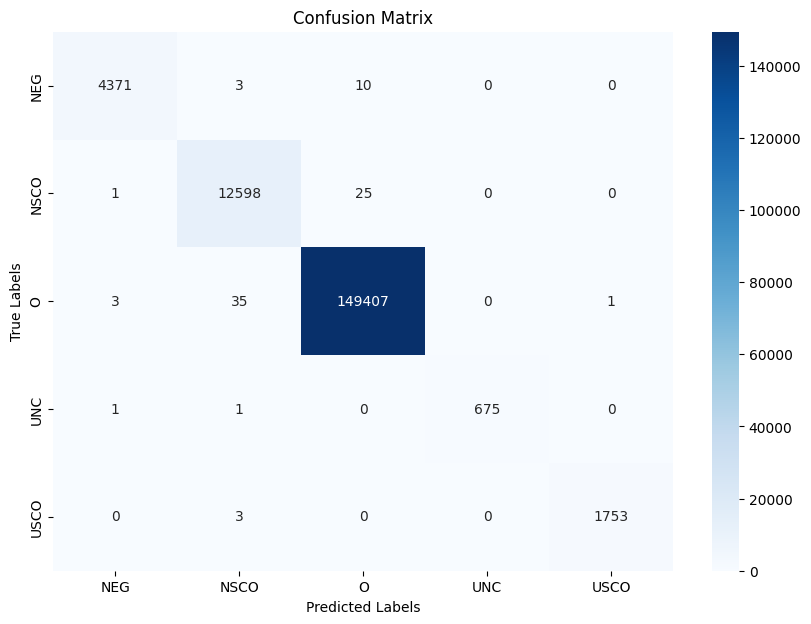

In [105]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

def plot_confusion_matrix(y_true, y_pred, labels):
    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    # Plot the confusion matrix using seaborn
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Example usage:
# Assume 'y_train_flat' and 'predictions_flat' are the flattened true labels and predictions
# You should also provide the list of unique labels as they appear in your dataset
unique_labels = sorted(set(y_train_flat))  # Replace with your actual list of labels
plot_confusion_matrix(y_train_flat, predictions_flat, unique_labels)
